In [115]:
import os
import pandas as pd
import numpy as np

import matplotlib.image as mpimg
import os
import matplotlib.pyplot as plt

from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection

import time

import matplotlib.image as mpimg

import imageio
import shutil

In [116]:
from google.colab import drive


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:

base_dir = "/content/drive/MyDrive/vr2/"
csv_path = base_dir+"wellbeing_surveys.csv"

df_inicial = pd.read_csv(csv_path)

print(df_inicial.sample(5))

df_inicial.info()

           Timestamp  FRUITS_VEGGIES DAILY_STRESS  PLACES_VISITED  \
10223   2/1/19 19:48               4            5               7   
7798         11/8/17               3            3               2   
14653  9/23/20 13:55               4            4               2   
9047         7/20/18               4            3               4   
10531   3/26/19 4:02               2            2               0   

       CORE_CIRCLE  SUPPORTING_OTHERS  SOCIAL_NETWORK  ACHIEVEMENT  DONATION  \
10223            9                  8              10           10         5   
7798             7                  7              10            3         2   
14653            3                  9               2            2         5   
9047             3                  7               3            9         3   
10531            1                  1               2            3         0   

       BMI_RANGE  ...  SLEEP_HOURS  LOST_VACATION  DAILY_SHOUTING  \
10223          2  ...            6 

In [118]:
grouped_dimensions = {
    'Body': ['FRUITS_VEGGIES', 'BMI_RANGE_neg', 'DAILY_STEPS', 'SLEEP_HOURS'],
    'Mind': ['DAILY_STRESS_neg', 'FLOW', 'WEEKLY_MEDITATION', 'DAILY_SHOUTING_neg'],
    'Expertise': ['ACHIEVEMENT', 'PERSONAL_AWARDS', 'TIME_FOR_PASSION', 'TODO_COMPLETED'],
    'Connection': ['PLACES_VISITED', 'CORE_CIRCLE', 'SUPPORTING_OTHERS', 'SOCIAL_NETWORK'],
    'Purpose': ['DONATION', 'LOST_VACATION_neg', 'SUFFICIENT_INCOME', 'LIVE_VISION'],
}

column_mapping = {
    col.replace('_neg', ''): f"{dim}_{col}"
    for dim, cols in grouped_dimensions.items()
    for col in cols
}

dimensions = list(grouped_dimensions.keys())
values_list = list(column_mapping.values())

In [119]:
df_int = (
    df_inicial
    .drop(columns=['Timestamp', 'WORK_LIFE_BALANCE_SCORE'])
    .assign(DAILY_STRESS=lambda x: pd.to_numeric(x['DAILY_STRESS'], errors='coerce'))
    .dropna()
    .rename(columns=column_mapping)
)

df_int['AGE'] = df_int['AGE'].replace('Less than 20', '20 or less')

binary_cols = ['Body_BMI_RANGE_neg', 'Purpose_SUFFICIENT_INCOME']
df_int[binary_cols] = df_int[binary_cols] - 1

score_cols = [col for col in df_int.columns if col not in ['AGE', 'GENDER']]
df_int[score_cols] = df_int[score_cols].astype(int)

df_int.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15971 entries, 0 to 15971
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Body_FRUITS_VEGGIES           15971 non-null  int64 
 1   Mind_DAILY_STRESS_neg         15971 non-null  int64 
 2   Connection_PLACES_VISITED     15971 non-null  int64 
 3   Connection_CORE_CIRCLE        15971 non-null  int64 
 4   Connection_SUPPORTING_OTHERS  15971 non-null  int64 
 5   Connection_SOCIAL_NETWORK     15971 non-null  int64 
 6   Expertise_ACHIEVEMENT         15971 non-null  int64 
 7   Purpose_DONATION              15971 non-null  int64 
 8   Body_BMI_RANGE_neg            15971 non-null  int64 
 9   Expertise_TODO_COMPLETED      15971 non-null  int64 
 10  Mind_FLOW                     15971 non-null  int64 
 11  Body_DAILY_STEPS              15971 non-null  int64 
 12  Purpose_LIVE_VISION           15971 non-null  int64 
 13  Body_SLEEP_HOURS     

In [120]:
df_int.to_csv('processed_survey_data.csv', index=False)

In [121]:
answers_lookup = {}
stats = df_int[values_list].agg(['max'])

for col in values_list:
    mx = stats.loc['max', col]

    possible_vals = np.arange(int(mx) + 1)

    answers_lookup[col] = possible_vals.tolist()

answers_lookup

{'Body_FRUITS_VEGGIES': [0, 1, 2, 3, 4, 5],
 'Body_BMI_RANGE_neg': [0, 1],
 'Body_DAILY_STEPS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Body_SLEEP_HOURS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Mind_DAILY_STRESS_neg': [0, 1, 2, 3, 4, 5],
 'Mind_FLOW': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Mind_WEEKLY_MEDITATION': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Mind_DAILY_SHOUTING_neg': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Expertise_ACHIEVEMENT': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Expertise_PERSONAL_AWARDS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Expertise_TIME_FOR_PASSION': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Expertise_TODO_COMPLETED': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Connection_PLACES_VISITED': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Connection_CORE_CIRCLE': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Connection_SUPPORTING_OTHERS': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Connection_SOCIAL_NETWORK': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'Purpose_DONATION': [0, 1, 2, 3, 4, 5],
 'Purpose_LOST_VACATION

In [122]:
feedback_labels = {
    1: "Better than average",
    0: "In average",
    -1: "Worse than average"
}

nps_lookup = {}

stats = df_int[values_list].agg(['mean', 'std', 'max'])

for col in values_list:
    mu, sigma, mx = stats.loc[['mean', 'std', 'max'], col]

    possible_vals = np.arange(int(mx) + 1)

    z = (possible_vals - mu) / sigma if sigma > 0 else np.zeros_like(possible_vals)

    raw_scores = (z > 0.5).astype(int) - (z < -0.5).astype(int)

    multiplier = -1 if '_neg' in col else 1
    nps_lookup[col] = (raw_scores * multiplier).tolist()

nps_lookup

{'Body_FRUITS_VEGGIES': [-1, -1, -1, 0, 1, 1],
 'Body_BMI_RANGE_neg': [1, -1],
 'Body_DAILY_STEPS': [-1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1],
 'Body_SLEEP_HOURS': [-1, -1, -1, -1, -1, -1, -1, 0, 1, 1, 1],
 'Mind_DAILY_STRESS_neg': [1, 1, 1, 0, -1, -1],
 'Mind_FLOW': [-1, -1, -1, 0, 0, 1, 1, 1, 1, 1, 1],
 'Mind_WEEKLY_MEDITATION': [-1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1],
 'Mind_DAILY_SHOUTING_neg': [1, 1, 0, 0, 0, -1, -1, -1, -1, -1, -1],
 'Expertise_ACHIEVEMENT': [-1, -1, -1, 0, 0, 0, 1, 1, 1, 1, 1],
 'Expertise_PERSONAL_AWARDS': [-1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1],
 'Expertise_TIME_FOR_PASSION': [-1, -1, 0, 0, 0, 1, 1, 1, 1, 1, 1],
 'Expertise_TODO_COMPLETED': [-1, -1, -1, -1, -1, 0, 0, 0, 1, 1, 1],
 'Connection_PLACES_VISITED': [-1, -1, -1, -1, 0, 0, 0, 1, 1, 1, 1],
 'Connection_CORE_CIRCLE': [-1, -1, -1, -1, -1, 0, 0, 1, 1, 1, 1],
 'Connection_SUPPORTING_OTHERS': [-1, -1, -1, -1, 0, 0, 0, 0, 1, 1, 1],
 'Connection_SOCIAL_NETWORK': [-1, -1, -1, -1, -1, 0, 0, 0, 0, 1, 1],
 'Purpose_DO

In [123]:
n = len(df_int)

value_norm = {}

for col in values_list:
    cdf = df_int[col].value_counts().sort_index().cumsum()

    norm_scores = cdf / n

    max_val = int(df_int[col].max())
    norm_scores = norm_scores.reindex(range(max_val + 1), method='ffill').fillna(0)

    scores_list = norm_scores.tolist()

    if '_neg' in col:
        scores_list = scores_list[::-1]

    value_norm[col] = [round(x, 4) for x in scores_list]

value_norm

{'Body_FRUITS_VEGGIES': [0.0346, 0.1861, 0.4097, 0.6436, 0.8033, 1.0],
 'Body_BMI_RANGE_neg': [1.0, 0.5894],
 'Body_DAILY_STEPS': [0.0,
  0.0783,
  0.1729,
  0.2711,
  0.3652,
  0.5005,
  0.6005,
  0.6901,
  0.7867,
  0.8309,
  1.0],
 'Body_SLEEP_HOURS': [0.0,
  0.0011,
  0.0024,
  0.0055,
  0.0213,
  0.0855,
  0.2981,
  0.6466,
  0.9174,
  0.9791,
  1.0],
 'Mind_DAILY_STRESS_neg': [1.0, 0.8715, 0.6862, 0.4108, 0.1975, 0.0423],
 'Mind_FLOW': [0.0833,
  0.2701,
  0.4705,
  0.6261,
  0.7409,
  0.8338,
  0.8981,
  0.9347,
  0.9692,
  0.9788,
  1.0],
 'Mind_WEEKLY_MEDITATION': [0.0186,
  0.0625,
  0.1352,
  0.2284,
  0.3104,
  0.4342,
  0.4995,
  0.6419,
  0.7041,
  0.7317,
  1.0],
 'Mind_DAILY_SHOUTING_neg': [1.0,
  0.9508,
  0.9418,
  0.9181,
  0.8762,
  0.8421,
  0.7637,
  0.6851,
  0.5536,
  0.3854,
  0.1522],
 'Expertise_ACHIEVEMENT': [0.0815,
  0.1814,
  0.3446,
  0.5035,
  0.6186,
  0.7457,
  0.8174,
  0.8683,
  0.9117,
  0.9267,
  1.0],
 'Expertise_PERSONAL_AWARDS': [0.0341,
  0.07

In [124]:
n = len(df_int)

value_freq = {}

for col in values_list:
    counts = df_int[col].value_counts().sort_index()

    max_val = int(df_int[col].max())
    counts = counts.reindex(range(max_val + 1), fill_value=0)

    value_freq[col] = counts.tolist()

value_freq

{'Body_FRUITS_VEGGIES': [552, 2421, 3570, 3736, 2551, 3141],
 'Body_BMI_RANGE_neg': [9413, 6558],
 'Body_DAILY_STEPS': [0,
  1251,
  1511,
  1567,
  1504,
  2161,
  1597,
  1431,
  1543,
  706,
  2700],
 'Body_SLEEP_HOURS': [0, 18, 21, 49, 252, 1025, 3396, 5566, 4324, 987, 333],
 'Mind_DAILY_STRESS_neg': [676, 2478, 3407, 4398, 2960, 2052],
 'Mind_FLOW': [1330, 2983, 3202, 2485, 1833, 1483, 1028, 584, 551, 154, 338],
 'Mind_WEEKLY_MEDITATION': [297,
  701,
  1162,
  1487,
  1310,
  1977,
  1043,
  2275,
  993,
  441,
  4285],
 'Mind_DAILY_SHOUTING_neg': [2430,
  3726,
  2685,
  2101,
  1255,
  1252,
  545,
  669,
  378,
  145,
  785],
 'Expertise_ACHIEVEMENT': [1302,
  1595,
  2606,
  2538,
  1838,
  2030,
  1145,
  814,
  693,
  240,
  1170],
 'Expertise_PERSONAL_AWARDS': [545,
  713,
  1382,
  1881,
  1733,
  2210,
  1344,
  1118,
  946,
  335,
  3764],
 'Expertise_TIME_FOR_PASSION': [1797,
  3285,
  2781,
  1962,
  1504,
  1229,
  998,
  635,
  905,
  193,
  682],
 'Expertise_TODO_C

In [125]:
def plot_column_context(column_name, user_value):
    status_map = {
        1:  {'color': '#2ecc71', 'label': 'Better than average'},
        0:  {'color': '#f39c12', 'label': 'In average'},
        -1: {'color': '#e74c3c', 'label': 'Worse than average'}
    }

    freqs = value_freq[column_name]
    x_indices = range(len(freqs))

    safe_idx = min(user_value, len(nps_lookup[column_name]) - 1)
    nps_score = nps_lookup[column_name][safe_idx]

    status_info = status_map[nps_score]
    highlight_color = status_info['color']
    status_text = status_info['label']

    fig, ax = plt.subplots(figsize=(8, 4))

    bar_colors = ['#ecf0f1'] * len(freqs)
    if user_value < len(bar_colors):
        bar_colors[user_value] = highlight_color

    ax.bar(x_indices, freqs, color=bar_colors, edgecolor='none')

    ax.grid(False)

    for spine in ax.spines.values():
        spine.set_visible(False)

    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['bottom'].set_color('gray')

    ax.set_xticks([])
    ax.set_yticks([])

    title_str = f"{column_name}\nYour Value: {user_value} | Status: {status_text}"
    plt.figtext(0.5, -0.05, title_str, wrap=True, horizontalalignment='center',
                fontsize=12, fontweight='bold', color=highlight_color)

    plt.tight_layout()
    plt.show()

  [OK] Loaded Body: icons/icon_body.png
  [OK] Loaded Mind: icons/icon_mind.png
  [OK] Loaded Expertise: icons/icon_expertise.png
  [OK] Loaded Connection: icons/icon_connection.png
  [OK] Loaded Purpose: icons/icon_purpose.png


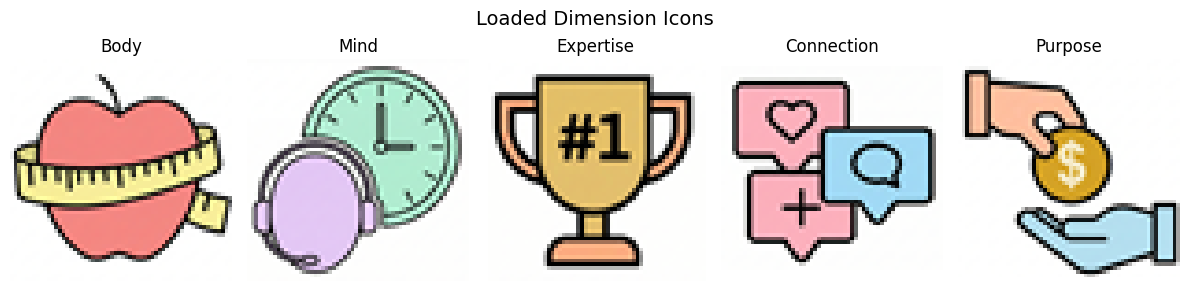

In [126]:
icon_files = {
    'Body':       'icons/icon_body.png',
    'Mind':       'icons/icon_mind.png',
    'Expertise':  'icons/icon_expertise.png',
    'Connection': 'icons/icon_connection.png',
    'Purpose':    'icons/icon_purpose.png'
}

dimension_icons = {}

for dim, filename in icon_files.items():
    full_path = os.path.join(base_dir, filename)

    try:
        img = mpimg.imread(full_path)
        dimension_icons[dim] = img
        print(f"  [OK] Loaded {dim}: {filename}")

    except FileNotFoundError:
        print(f"  [!!] Error: Could not find file at {full_path}")
        dimension_icons[dim] = np.ones((60, 60, 3))

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
fig.suptitle("Loaded Dimension Icons", fontsize=14)

for ax, dim in zip(axes, dimensions):
    if dim in dimension_icons:
        ax.imshow(dimension_icons[dim])
        ax.set_title(dim)
        ax.axis('off')
    else:
        ax.set_title(f"{dim} (Missing)")
        ax.axis('off')

plt.tight_layout()
plt.show()

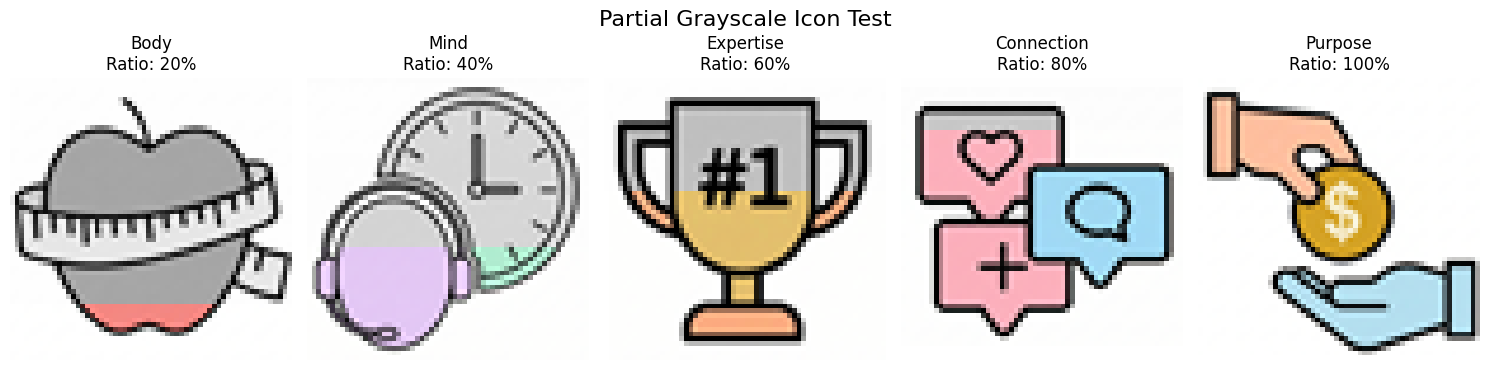

In [127]:

def get_partial_grayscale_icon(icon_array, ratio):
    processed = icon_array.copy()
    rows, cols, channels = processed.shape
    split_row = int(rows * (1 - ratio))
    top_section = processed[:split_row, :, :]
    gray_vals = np.dot(top_section[..., :3], [0.2989, 0.5870, 0.1140])
    top_section[..., 0] = gray_vals # Red
    top_section[..., 1] = gray_vals # Green
    top_section[..., 2] = gray_vals # Blue
    return processed

test_ratios = [0.2, 0.4, 0.6, 0.8, 1.0]

fig, axes = plt.subplots(1, 5, figsize=(15, 4))
fig.suptitle("Partial Grayscale Icon Test", fontsize=16)

for ax, dim, ratio in zip(axes, dimensions, test_ratios):

    if dim in dimension_icons:
        original_icon = dimension_icons[dim]

        modified_icon = get_partial_grayscale_icon(original_icon, ratio)

        ax.imshow(modified_icon)
        ax.set_title(f"{dim}\nRatio: {ratio*100:.0f}%", fontsize=12)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [128]:

def draw_histogram_on_ax(ax, full_col_name, user_value):
    # 1. Lookups
    freqs = value_freq[full_col_name]
    safe_idx = min(user_value, len(nps_lookup[full_col_name]) - 1)
    nps_score = nps_lookup[full_col_name][safe_idx]

    status_map = {
        1:  {'color': '#2ecc71', 'label': 'Better'},
        0:  {'color': '#f39c12', 'label': 'Average'},
        -1: {'color': '#e74c3c', 'label': 'Worse'}
    }
    status = status_map.get(nps_score, {'color': 'gray', 'label': 'Unknown'})

    bar_colors = ['#ecf0f1'] * len(freqs)
    if user_value < len(bar_colors):
        bar_colors[user_value] = status['color']

    ax.bar(range(len(freqs)), freqs, color=bar_colors, edgecolor='none')

    ax.grid(False)
    ax.axis('off')

    ax.spines['bottom'].set_visible(True)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['bottom'].set_color('gray')

    display_name = full_col_name.split('_', 1)[1] if '_' in full_col_name else full_col_name

    title_str = f"{display_name}\nVal: {user_value} | {status['label']}"
    ax.text(0.5, -0.15, title_str, transform=ax.transAxes,
            fontsize=9, fontweight='bold', color=status['color'],
            ha='center', va='top')


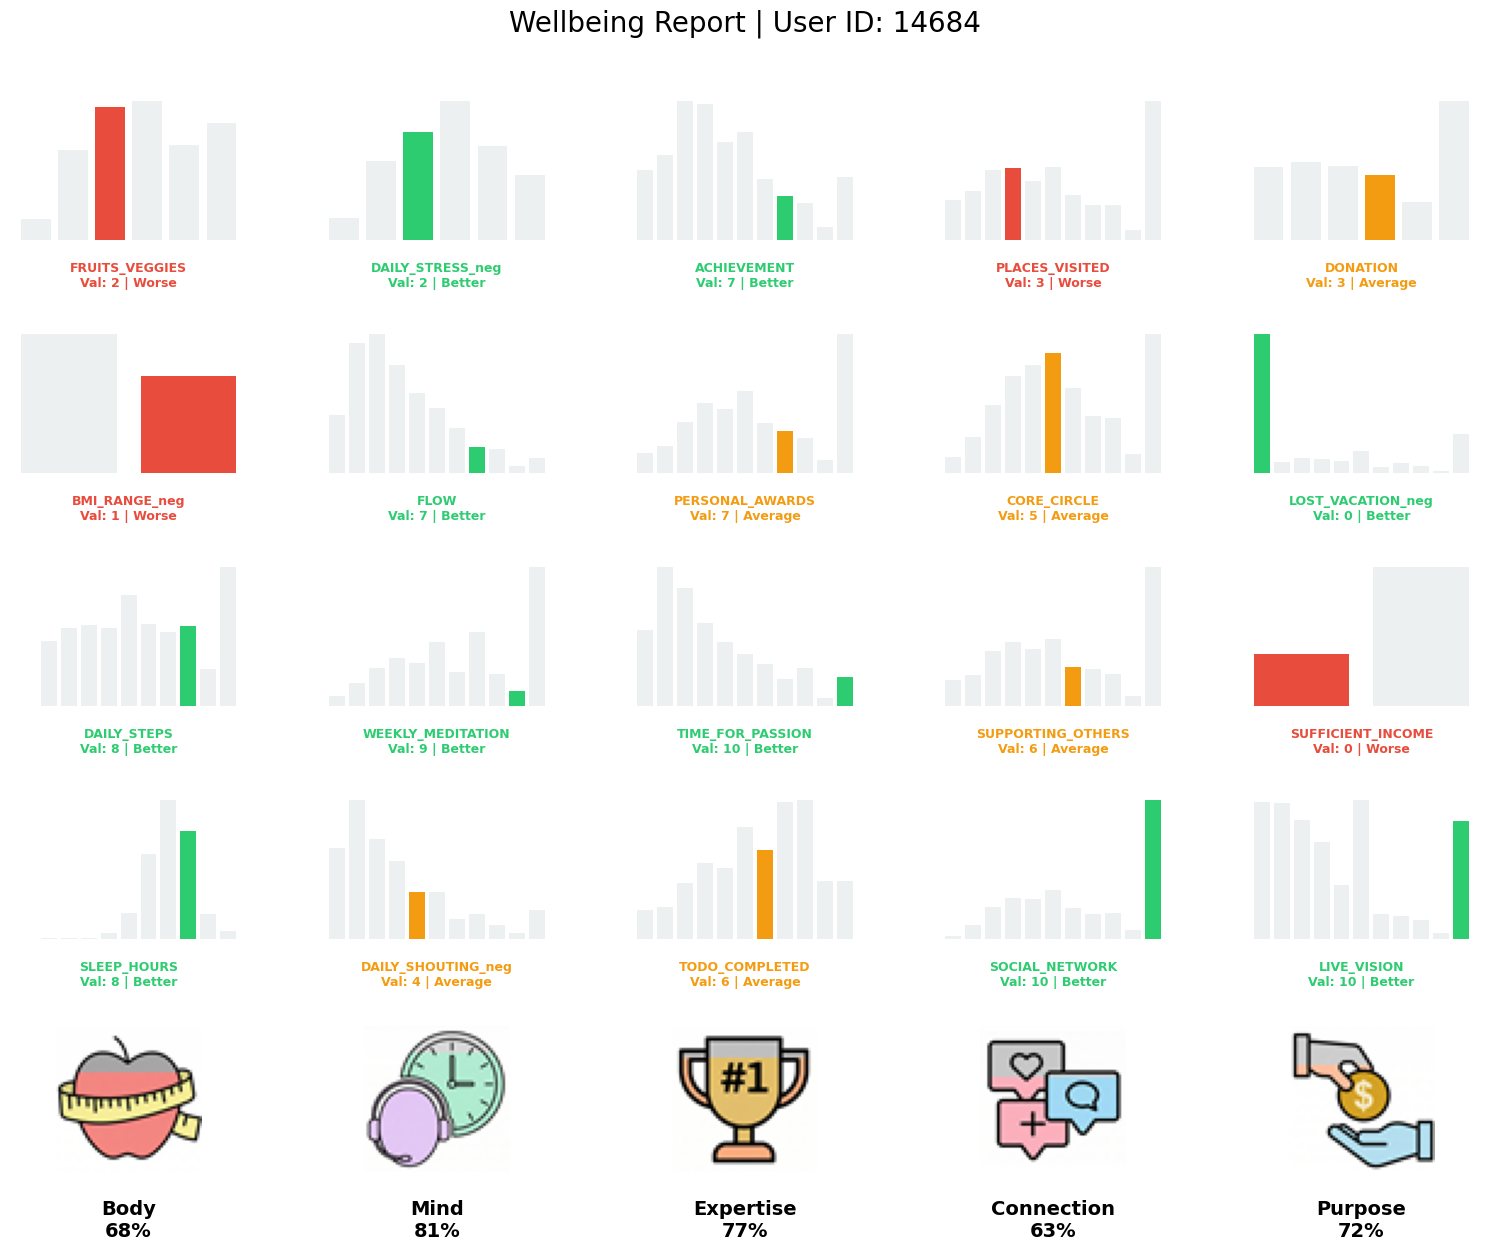

In [129]:
def plot_survey_grid(row_idx):
    user_row = df_int.loc[row_idx]

    fig, axes = plt.subplots(5, 5, figsize=(15, 14))
    fig.suptitle(f"Wellbeing Report | User ID: {row_idx}", fontsize=20, y=0.98)

    for col_idx, (dim, metrics) in enumerate(grouped_dimensions.items()):
        dim_ranks = []

        for row_idx_plot, metric in enumerate(metrics):
            ax = axes[row_idx_plot, col_idx]
            full_col = f"{dim}_{metric}"
            val = int(user_row[full_col])

            draw_histogram_on_ax(ax, full_col, val)

            norm_arr = value_norm[full_col]
            safe_idx = min(val, len(norm_arr) - 1)
            dim_ranks.append(norm_arr[safe_idx])

        # Target the bottom row for icons and summary text
        ax_icon = axes[4, col_idx]
        avg_ratio = sum(dim_ranks) / len(dim_ranks) if dim_ranks else 0

        if dim in dimension_icons:
            icon_img = get_partial_grayscale_icon(dimension_icons[dim], avg_ratio)
            ax_icon.imshow(icon_img)

        ax_icon.axis('off')

        # CHANGED: Lowered 'y' to -0.25 and added va='top' to move text further below icon
        ax_icon.set_title(f"{dim}\n{avg_ratio*100:.0f}%",
                          y=-0.25,
                          fontsize=14,
                          fontweight='bold',
                          verticalalignment='top')

    plt.tight_layout()
    # Ensure there is enough room at the bottom for the shifted labels
    plt.subplots_adjust(top=0.92, hspace=0.6, wspace=0.3, bottom=0.15)
    plt.show()

random_idx = df_int.sample(1).index[0]
plot_survey_grid(random_idx)

In [130]:
COLORS = {
    'green': '#2ecc71',
    'orange': '#f39c12',
    'red': '#e74c3c',
    'grey': '#bdc3c7'
}

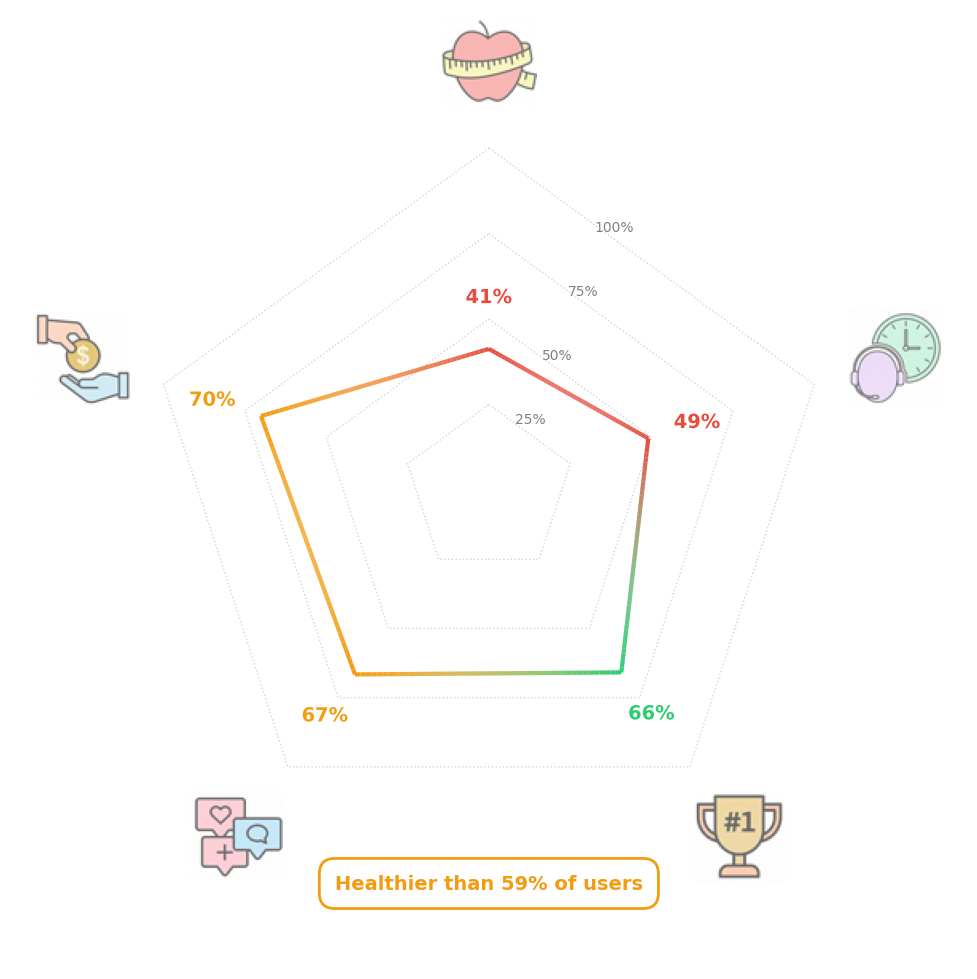

In [131]:
def plot_radar_wellbeing(row_idx):
    user_row = df_int.loc[row_idx]

    dim_ranks = []
    dim_nps = []

    for dim in dimensions:
        cols = [f"{dim}_{m}" for m in grouped_dimensions[dim]]
        raw_vals = [int(user_row[c]) for c in cols]

        ranks = [value_norm[c][min(v, len(value_norm[c])-1)]
                 for c, v in zip(cols, raw_vals)]

        nps_scores = [nps_lookup[c][min(v, len(nps_lookup[c])-1)]
                      for c, v in zip(cols, raw_vals)]

        dim_ranks.append(sum(ranks) / len(ranks) if ranks else 0)
        dim_nps.append(sum(nps_scores) / len(nps_scores) if nps_scores else 0)

    overall_health = sum(dim_ranks) / len(dim_ranks) if dim_ranks else 0

    if overall_health > 0.6:
        overall_color = COLORS['green']
    elif overall_health > 0.4:
        overall_color = COLORS['orange']
    else:
        overall_color = COLORS['red']

    num_vars = len(dimensions)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.spines['polar'].set_visible(False)
    ax.set_xticks([])
    ax.set_ylim(0, 1.4)
    ax.grid(False)

    grid_levels = [0.25, 0.50, 0.75, 1.0]
    for level in grid_levels:
        ax.plot(angles + [angles[0]], [level] * (len(angles)+1),
                color=COLORS['grey'], linestyle=':', linewidth=1, alpha=0.7)

    ax.set_yticks([l * 0.809 for l in grid_levels])
    ax.set_yticklabels([f"{l*100:.0f}%" for l in grid_levels], color="grey", size=10)

    # Internal helper function for gradient lines
    def draw_gradient_segment(theta_start, r_start, theta_end, r_end, c_hex, alpha_start, alpha_end):
        n_points = 50
        t_vals = np.linspace(0, 1, n_points)

        x1, y1 = r_start * np.cos(theta_start), r_start * np.sin(theta_start)
        x2, y2 = r_end * np.cos(theta_end), r_end * np.sin(theta_end)

        xs = x1 * (1 - t_vals) + x2 * t_vals
        ys = y1 * (1 - t_vals) + y2 * t_vals
        rs = np.sqrt(xs**2 + ys**2)
        ts = np.arctan2(ys, xs)

        ts = np.unwrap(ts)

        points = np.array([ts, rs]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        rgb = mcolors.to_rgb(c_hex)
        alphas = np.linspace(alpha_start, alpha_end, n_points)
        rgba = np.zeros((n_points - 1, 4))
        rgba[:, :3] = rgb
        rgba[:, 3] = alphas[:-1]

        lc = LineCollection(segments, colors=rgba, linewidth=3)
        ax.add_collection(lc)

    N = len(dimensions)
    for i in range(N):
        val = dim_nps[i]
        line_color = COLORS['green'] if val >= 0.5 else (COLORS['red'] if val <= -0.5 else COLORS['orange'])

        prev_i = (i - 1) % N
        next_i = (i + 1) % N

        theta_c, r_c = angles[i], dim_ranks[i]
        theta_p, r_p = angles[prev_i], dim_ranks[prev_i]
        theta_n, r_n = angles[next_i], dim_ranks[next_i]

        t_start_prev = theta_p - 2*np.pi if prev_i > i else theta_p
        t_end_next = theta_n + 2*np.pi if next_i < i else theta_n

        draw_gradient_segment(t_start_prev, r_p, theta_c, r_c, line_color, 0.0, 1.0)
        draw_gradient_segment(theta_c, r_c, t_end_next, r_n, line_color, 1.0, 0.0)

    for i, dim in enumerate(dimensions):
        if dim in dimension_icons:
            img = dimension_icons[dim].copy()
            if img.shape[2] == 4:
                img[:, :, 3] *= 0.6

            imagebox = OffsetImage(img, zoom=1.15)
            ab = AnnotationBbox(imagebox, (angles[i], 1.25), frameon=False)
            ax.add_artist(ab)

        val = dim_nps[i]
        txt_color = COLORS['green'] if val >= 0.5 else (COLORS['red'] if val <= -0.5 else COLORS['orange'])

        ax.text(angles[i], dim_ranks[i] + 0.15, f"{dim_ranks[i]*100:.0f}%",
                ha='center', va='center', fontweight='bold', fontsize=14, color=txt_color,
                path_effects=[path_effects.withStroke(linewidth=2, foreground='white')])

    ax.text(np.pi, 1.15, f"Healthier than {overall_health*100:.0f}% of users",
            ha='center', va='center', fontsize=14, fontweight='bold', color=overall_color,
            bbox=dict(boxstyle="round,pad=0.8", fc="white", ec=overall_color, lw=2))

    plt.tight_layout()
    plt.show()

# Execution
random_row = df_int.sample(1)
idx = random_row.index[0]
plot_radar_wellbeing(idx)

In [132]:
def plot_wellbeing_radar(input_data, save_path=None, show_summary=True):

    if isinstance(input_data, (int, np.integer)):
        row_indices = [input_data]
        mode = 'single'
    else:
        row_indices = input_data
        mode = 'multi'

    total_indices = len(row_indices)
    start_time = time.time()

    if mode == 'single':
        base_alpha = 0.6
        n_points = 50
    else:
        base_alpha = np.sqrt(max(0.02, min(0.8, 1.0 / (total_indices * 0.2))))
        n_points = 10 if total_indices > 1000 else 30

    print(f"Plotting {mode.upper()} mode ({total_indices} surveys). Alpha: {base_alpha:.2f}")

    num_vars = len(dimensions)
    all_ranks = np.zeros((total_indices, num_vars))
    all_nps = np.zeros((total_indices, num_vars))
    current_data = df_int.loc[row_indices]

    for i, dim in enumerate(dimensions):
        short_cols = grouped_dimensions[dim]
        full_cols = [f"{dim}_{col}" for col in short_cols]
        raw_vals = current_data[full_cols].values

        dim_rank_accum = np.zeros(total_indices)
        dim_nps_accum = np.zeros(total_indices)

        for c_idx, full_col in enumerate(full_cols):
            col_vals = raw_vals[:, c_idx].astype(int)
            norm_ref = np.array(value_norm[full_col])
            safe_indices = np.clip(col_vals, 0, len(norm_ref) - 1)
            dim_rank_accum += norm_ref[safe_indices]

            nps_ref = np.array(nps_lookup[full_col])
            safe_nps_indices = np.clip(col_vals, 0, len(nps_ref) - 1)
            dim_nps_accum += nps_ref[safe_nps_indices]

        all_ranks[:, i] = dim_rank_accum / len(full_cols)
        all_nps[:, i] = dim_nps_accum / len(full_cols)

    raw_angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)
    plot_angles = np.pi / 2 - raw_angles

    theta_curr = plot_angles[np.newaxis, :]
    r_curr = all_ranks
    theta_prev = np.roll(theta_curr, 1, axis=1)
    r_prev = np.roll(r_curr, 1, axis=1)
    theta_next = np.roll(theta_curr, -1, axis=1)
    r_next = np.roll(r_curr, -1, axis=1)

    def polar_to_cart(r, theta):
        return r * np.cos(theta), r * np.sin(theta)

    xp, yp = polar_to_cart(r_prev, theta_prev)
    xc, yc = polar_to_cart(r_curr, theta_curr)
    xn, yn = polar_to_cart(r_next, theta_next)

    t = np.linspace(0, 1, n_points).reshape(1, 1, -1)
    xs1 = xp[:, :, np.newaxis] * (1 - t) + xc[:, :, np.newaxis] * t
    ys1 = yp[:, :, np.newaxis] * (1 - t) + yc[:, :, np.newaxis] * t
    xs2 = xc[:, :, np.newaxis] * (1 - t) + xn[:, :, np.newaxis] * t
    ys2 = yc[:, :, np.newaxis] * (1 - t) + yn[:, :, np.newaxis] * t

    cond_green = all_nps >= 0.5
    cond_red = all_nps <= -0.5
    cond_orange = ~(cond_green | cond_red)

    base_colors = np.zeros((total_indices, num_vars, 3))
    base_colors[cond_green] = mcolors.to_rgb(COLORS['green'])
    base_colors[cond_red] = mcolors.to_rgb(COLORS['red'])
    base_colors[cond_orange] = mcolors.to_rgb(COLORS['orange'])

    def process_batch(xs, ys, alpha_seq):
        points = np.stack([xs, ys], axis=-1)
        segments = np.stack([points[:, :, :-1, :], points[:, :, 1:, :]], axis=-2)
        flat_segments = segments.reshape(-1, 2, 2)
        c_expanded = np.repeat(base_colors[:, :, np.newaxis, :], n_points - 1, axis=2)
        c_flat = c_expanded.reshape(-1, 3)
        a_tiled = np.tile(alpha_seq[:-1], total_indices * num_vars)
        return flat_segments, np.column_stack([c_flat, a_tiled])

    alpha_seq1 = np.linspace(0, base_alpha, n_points)
    alpha_seq2 = np.linspace(base_alpha, 0, n_points)

    segs1, colors1 = process_batch(xs1, ys1, alpha_seq1)
    segs2, colors2 = process_batch(xs2, ys2, alpha_seq2)

    final_segments = np.concatenate([segs1, segs2], axis=0)
    final_colors = np.concatenate([colors1, colors2], axis=0)

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_xlim(-1.6, 1.6)
    ax.set_ylim(-1.6, 1.6)

    grid_x = np.cos(plot_angles)
    grid_y = np.sin(plot_angles)

    lc = LineCollection(final_segments, colors=final_colors, linewidth=2 if mode=='multi' else 4, zorder=5)
    ax.add_collection(lc)

    if mode == 'multi':
        g_color = 'grey'
        g_style = '--'
        g_width = 1.2
        g_alpha = 0.8
        g_zorder = 6
    else:
        g_color = COLORS['grey']
        g_style = ':'
        g_width = 1.2
        g_alpha = 0.6
        g_zorder = 0

    grid_levels = [0.25, 0.50, 0.75, 1.0]

    for level in grid_levels:
        gx = grid_x * level
        gy = grid_y * level
        gx_plot = np.append(gx, gx[0])
        gy_plot = np.append(gy, gy[0])

        ax.plot(gx_plot, gy_plot,
                color=g_color,
                linestyle=g_style,
                linewidth=g_width,
                alpha=g_alpha,
                zorder=g_zorder)

    for i in range(num_vars):
        ax.plot([0, grid_x[i]], [0, grid_y[i]],
                color=g_color,
                linestyle=g_style,
                linewidth=g_width,
                alpha=g_alpha,
                zorder=g_zorder)

    for i, dim in enumerate(dimensions):
        ix = 1.25 * np.cos(plot_angles[i])
        iy = 1.25 * np.sin(plot_angles[i])

        if dim in dimension_icons:
            img_arr = np.array(dimension_icons[dim]).copy().astype(float)
            if img_arr.max() > 1.1: img_arr /= 255.0
            if img_arr.shape[2] == 3:
                img_arr = np.dstack((img_arr, np.ones((img_arr.shape[0], img_arr.shape[1]))))

            if mode == 'multi':
              img_arr[:, :, 3] *= 0.6

            imagebox = OffsetImage(img_arr, zoom=1.15)
            ab = AnnotationBbox(imagebox, (ix, iy), frameon=False, zorder=10)
            ax.add_artist(ab)

        if mode == 'single':
            rank_val = all_ranks[0, i]
            nps_val = all_nps[0, i]

            if nps_val >= 0.5: txt_color = COLORS['green']
            elif nps_val <= -0.5: txt_color = COLORS['red']
            else: txt_color = COLORS['orange']

            tx, ty = polar_to_cart(rank_val + 0.15, plot_angles[i])
            ax.text(tx, ty, f"{rank_val*100:.0f}%",
                    ha='center', va='center', fontweight='bold', fontsize=20, color=txt_color,
                    path_effects=[path_effects.withStroke(linewidth=3, foreground='white')],
                    zorder=20)

    if show_summary:
        if mode == 'single':
            overall_health = np.mean(all_ranks)
            if overall_health > 0.6: overall_c = COLORS['green']
            elif overall_health > 0.4: overall_c = COLORS['orange']
            else: overall_c = COLORS['red']
            summary_text = f"Healthier than {overall_health*100:.0f}% of users"
            summary_color = overall_c
        else:
            summary_text = f"{total_indices} surveys"
            summary_color = COLORS['grey']

        ax.text(0, -1.3, summary_text,
                ha='center', va='center', fontsize=20, fontweight='bold', color=summary_color,
                bbox=dict(boxstyle="round,pad=0.8", fc="white", ec=summary_color, lw=2),
                zorder=20)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', transparent=True)
        plt.close(fig)
        print(f"Saved to {save_path}")
    else:
        plt.show()



Plotting SINGLE mode (1 surveys). Alpha: 0.60


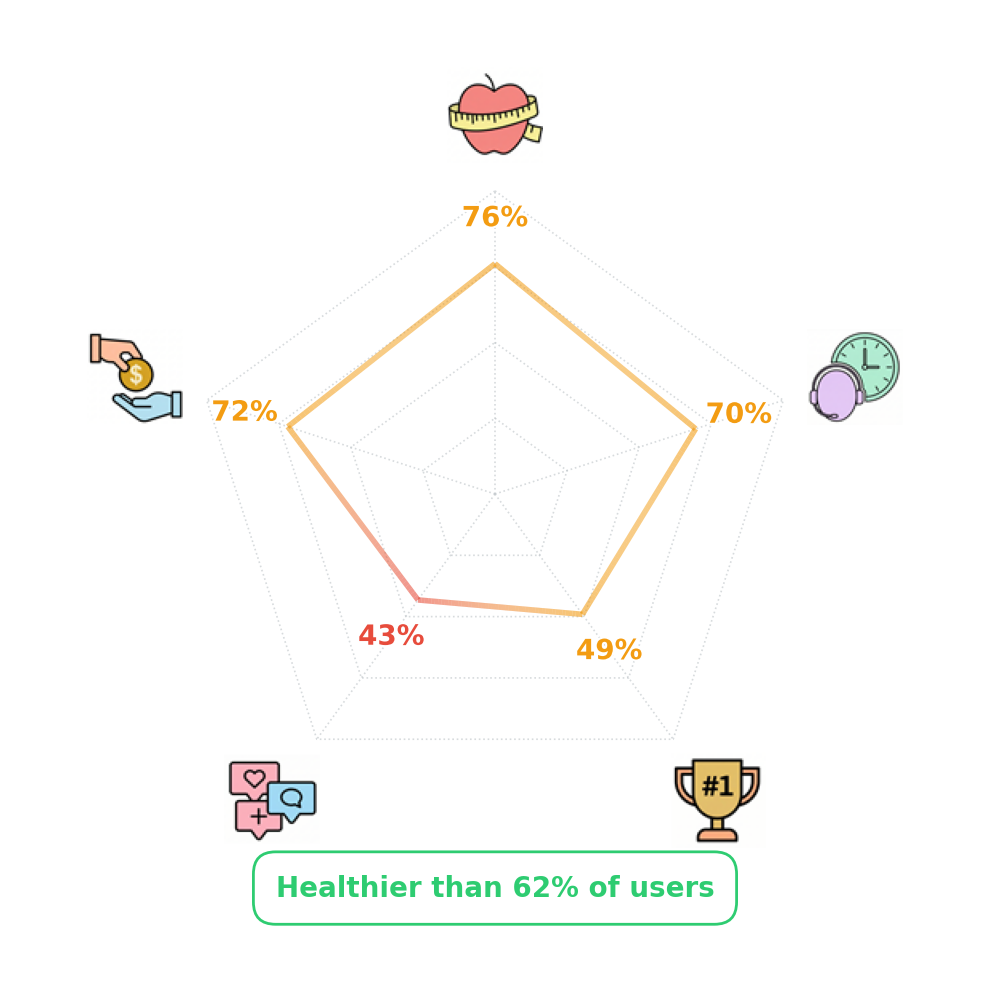

Plotting MULTI mode (50 surveys). Alpha: 0.32


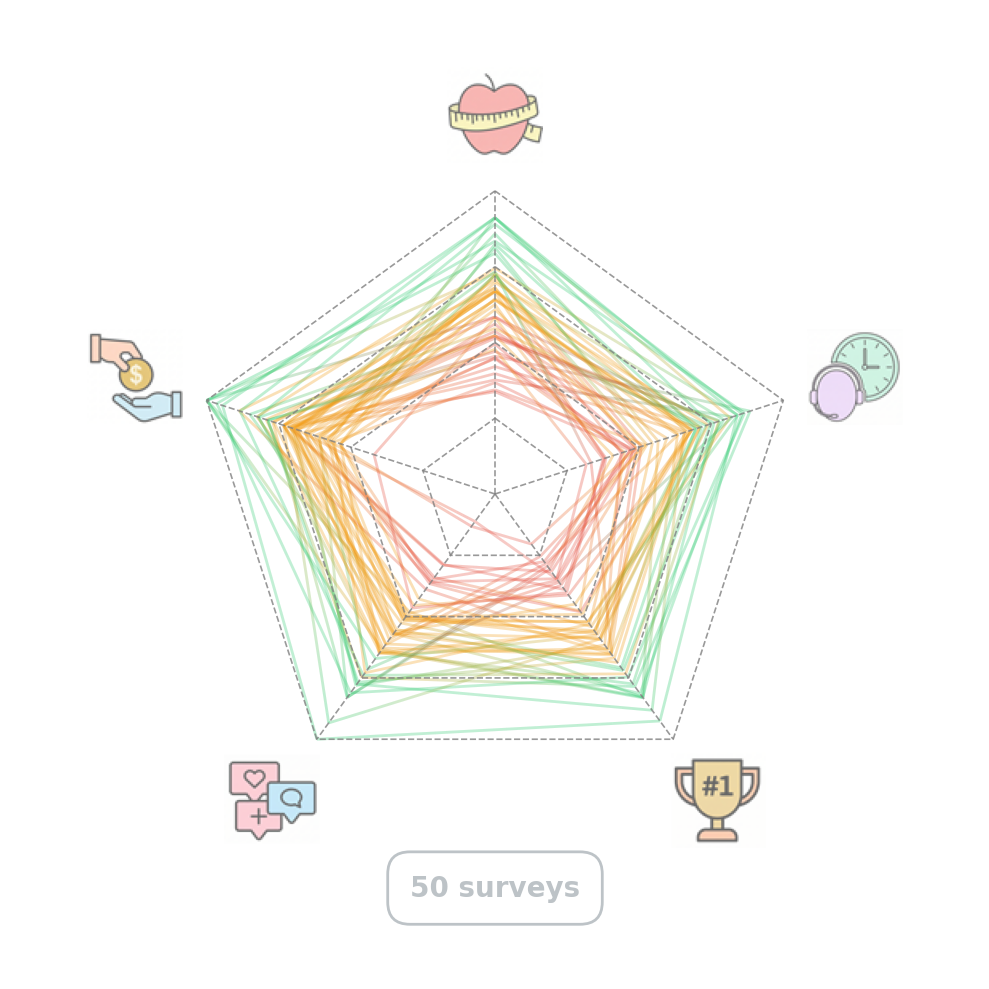

In [133]:
random_idx = df_int.sample(1).index[0]
plot_wellbeing_radar(random_idx)

sample_indices = df_int.sample(50).index.tolist()
plot_wellbeing_radar(sample_indices)

In [134]:
SAVE_DIR = os.path.join(base_dir, "radar_plots")
os.makedirs(SAVE_DIR, exist_ok=True)

def run_radar_benchmark(df, min_val=10, max_val=None, prefix="wellbeing_study"):

    max_val = max_val or len(df)

    sizes = np.geomspace(min_val, max_val, num=5).astype(int)
    sizes = np.unique(sizes[sizes <= len(df)])

    for n in sizes:
        indices = df.sample(n=n).index.tolist()
        save_path = os.path.join(SAVE_DIR, f"{prefix}_N{n}.png")
        plot_wellbeing_radar(indices, save_path=save_path)

In [135]:
run_radar_benchmark(df_int, min_val=10, max_val=None, prefix="wellbeing_study")

Plotting MULTI mode (10 surveys). Alpha: 0.71
Saved to /content/drive/MyDrive/vr2/radar_plots/wellbeing_study_N10.png
Plotting MULTI mode (63 surveys). Alpha: 0.28
Saved to /content/drive/MyDrive/vr2/radar_plots/wellbeing_study_N63.png
Plotting MULTI mode (399 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/radar_plots/wellbeing_study_N399.png
Plotting MULTI mode (2526 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/radar_plots/wellbeing_study_N2526.png
Plotting MULTI mode (15971 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/radar_plots/wellbeing_study_N15971.png


In [ ]:
# Define the style once to avoid errors, ensuring it includes fontweight
TEXT_STYLE = {'color': 'grey', 'alpha': 0.8, 'fontweight': 'bold'}

def create_grid_frame(frame_idx, temp_dir):
    """
    Runs the grid generation logic once and saves the result as an image.
    """
    ages = sorted(df_int['AGE'].unique())
    genders = ['Female', 'Male']

    row_cats = genders + ['Both']
    col_cats = ages + ['All']

    n_rows = len(row_cats)
    n_cols = len(col_cats)

    # Define the offset for the labels
    X_OFFSET = -0.1

    # Prepare figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
    plt.subplots_adjust(wspace=0.0, hspace=0.0)

    # Generate the grid
    for r, gender in enumerate(row_cats):
        for c, age in enumerate(col_cats):
            ax = axes[r, c]

            # Filter Data
            subset = df_int.copy()
            if gender != 'Both':
                subset = subset[subset['GENDER'] == gender]
            if age != 'All':
                subset = subset[subset['AGE'] == age]

            # Sample Data to create animation variance
            if len(subset) > 0:
                indices = subset.sample(n=300, replace=True).index.tolist()

                # Unique filename for this specific radar plot to avoid IO conflicts
                radar_filename = f"temp_radar_{frame_idx}_{r}_{c}.png"
                radar_path = os.path.join(temp_dir, radar_filename)

                # Plot radar to disk (summary text hidden)
                plot_wellbeing_radar(indices, save_path=radar_path, show_summary=False)

                # Load it back onto the grid axis
                if os.path.exists(radar_path):
                    img = mpimg.imread(radar_path)
                    ax.imshow(img)
            else:
                # Use TEXT_STYLE for consistent styling
                ax.text(0.5, 0.5, "No Data", ha='center', **TEXT_STYLE)

            # --- Styling the Grid ---
            ax.axis('off')

            # Draw grid lines between subplots
            if c == n_cols - 1:
                ax.plot([0, 0], [0, 1], transform=ax.transAxes, color='grey', linestyle=':', linewidth=3, alpha=0.5, clip_on=False)
            elif c < n_cols - 1:
                ax.plot([1, 1], [0, 1], transform=ax.transAxes, color='grey', linewidth=0.5, alpha=0.5, clip_on=False)

            if r == n_rows - 1:
                ax.plot([0, 1], [1, 1], transform=ax.transAxes, color='grey', linestyle=':', linewidth=3, alpha=0.5, clip_on=False)
            elif r < n_rows - 1:
                ax.plot([0, 1], [0, 0], transform=ax.transAxes, color='grey', linewidth=0.5, alpha=0.5, clip_on=False)

            # Headers (Top Row)
            if r == 0:
                ax.set_title(age, fontsize=12, pad=20, **TEXT_STYLE)

            # Row Labels (Left Column)
            if c == 0:
                ax.text(X_OFFSET, 0.5, gender, transform=ax.transAxes, va='center', ha='right', fontsize=12, **TEXT_STYLE)

            # "N = 300" Label (Top-Left Corner)
            if r == 0 and c == 0:
                # FIX: Removed explicit fontweight='bold' because it is already in **TEXT_STYLE
                ax.text(X_OFFSET, 1.15, "N = 300", transform=ax.transAxes, ha='right', va='center', fontsize=14, **TEXT_STYLE)

    # Save the full grid frame
    frame_path = os.path.join(temp_dir, f"grid_frame_{frame_idx}.png")
    plt.savefig(frame_path, dpi=100, bbox_inches='tight')
    plt.close(fig) # Clear memory
    return frame_path

In [ ]:
def demo_gif(n_frames=10, output_filename='wellbeing_grid_animation.gif'):
    print(f"Starting GIF generation ({n_frames} frames)...")

    temp_dir = os.path.join(base_dir, "temp_gif_frames")
    os.makedirs(temp_dir, exist_ok=True)

    frames = []

    try:
        for i in range(n_frames):
            print(f"  - Generating frame {i+1}/{n_frames}...")
            # Call the helper function defined above
            frame_path = create_grid_frame(i, temp_dir)

            # Read image for GIF
            frames.append(imageio.v3.imread(frame_path))

        print("Compiling GIF...")
        output_path = os.path.join(base_dir, output_filename)

        # duration=500 means 500ms per frame (2 FPS)
        imageio.mimsave(output_path, frames, duration=500, loop=0)

        print(f"Done! GIF saved to: {output_path}")

    finally:
        # Cleanup temporary files
        if os.path.exists(temp_dir):
            shutil.rmtree(temp_dir)
            print("Temporary files cleaned up.")

# Run the fixed function
#demo_gif(n_frames=10)

Starting GIF generation (10 frames)...
  - Generating frame 1/10...
Plotting MULTI mode (300 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/temp_gif_frames/temp_radar_0_0_0.png
Plotting MULTI mode (300 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/temp_gif_frames/temp_radar_0_0_1.png
Plotting MULTI mode (300 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/temp_gif_frames/temp_radar_0_0_2.png
Plotting MULTI mode (300 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/temp_gif_frames/temp_radar_0_0_3.png
Plotting MULTI mode (300 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/temp_gif_frames/temp_radar_0_0_4.png
Plotting MULTI mode (300 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/temp_gif_frames/temp_radar_0_1_0.png
Plotting MULTI mode (300 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/temp_gif_frames/temp_radar_0_1_1.png
Plotting MULTI mode (300 surveys). Alpha: 0.14
Saved to /content/drive/MyDrive/vr2/temp_gif_